# Fraction of variance in 20-100 day band

Plots maps of percent variance accounted for by intraseasonal time scale for CESM2 Large Ensemble.

info: https://www.cesm.ucar.edu/projects/community-projects/LENS2/

This makes maps that are consistent with the description in the MJO diagnostics paper: [doi: 10.1175/2008JCLI2731.1](https://doi.org/10.1175/2008JCLI2731.1)

## implementation notes

- Uses time series files of daily means. 
- Constructs a dictionary to figure out which macro/micro combinations are available.
- Currently is only working on the historical runs, and uses 1850-1899
- Currently makes plots for DJF
- Uses GeoCAT's bandpass filter that is based on FFT. 

In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
import geocat.comp as gc
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet as cc
import cartopy.crs as ccrs

In [18]:
def get_coord_bnds(crd):
    dcrd = crd[1]-crd[0]
    result = np.zeros(len(crd)+1)
    result[0:-1] = crd - 0.5*dcrd
    result[-1] = crd[-1]+0.5*dcrd
    return result

In [3]:
def season_selector(dset, season):
    in_season = dset.time.dt.season == season
    return dset.sel(time=in_season)


def calc_variance_filtered(fld, season=None):
    '''Calculate total and bandpass filtered variance from daily field, optionally for a given season.'''
    x_sampling_freq = 1 # 1 sample per day
    cflow = (1/100)
    cfhigh = (1/20)
    x_bandpass = gc.fourier_filters.fourier_band_pass(fld.sel(lat=slice(-30,30)), 1, cflow, cfhigh, time_axis=0)
    if season is not None:
        x_seas = season_selector(fld, season)
        x_bandpass_seas = season_selector(x_bandpass, season)
    else:
        x_seas = fld
        x_bandpass_seas = x_bandpass
    x_totalvariance = x_seas.sel(lat=slice(-30,30)).var(dim='time').compute()    
    x_bandpass_variance = x_bandpass_seas.sel(lat=slice(-30,30)).var(dim='time').compute()
    return x_totalvariance, x_bandpass_variance
    

In [41]:
def make_the_plot(vt, vf, titlestr=None, oname=None):

    lon_bnds = get_coord_bnds(vt.lon)
    lat_bnds = get_coord_bnds(vt.lat)
    fig, ax = plt.subplots(figsize=(12,4), subplot_kw={"projection":ccrs.PlateCarree()})

    color_norm = mpl.colors.Normalize(vmin=0.1, vmax=0.5)
    color_map = cc.cm.CET_L19
    img = ax.pcolormesh(lon_bnds, lat_bnds, vf/vt, rasterized=True, transform=ccrs.PlateCarree(), cmap=color_map, norm=color_norm)
    ax.contour(vt.lon, vt.lat, vt, colors='gray')
    ax.coastlines()
    ax.set_title(titlestr, loc='left')
    ax.text(0., -.2, "Lines: Total variance", rotation=0, transform=ax.transAxes)
    fig.colorbar(img, shrink=0.4, label="Fraction of variance\n in 20-100 day band")
    if oname is None:
        plt.show()
    else:
        fig.savefig(oname, bbox_inches='tight', dpi=200)
    return fig, ax

In [4]:
data_loc = Path("/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1")

In [9]:
# get all the MACRO / MICRO names:
all_files = list( (data_loc / "TS").glob("*.nc"))
print(f"For TS there are a total of {len(all_files)} files.")

all_files_names = pd.Series([f.name for f in all_files])
# all_files_split = [f.name.split(".") for f in all_files]


all_files_names_split = all_files_names.str.split(".", expand=True)

# all_files_names_split = all_files_names_split.rename(columns={'oldName1': 'newName1'
all_files_names_split.columns = ["coupling", "version", "compset", "resolution", "macro", "micro", "ostream", "hstream", "variable", "time_range", "suffix"]

all_compset_names = list(set(all_files_names_split['compset']))
print(f"All compset names: {all_compset_names}")

all_macro = list(set(all_files_names_split["macro"]))

all_micro = list(set(all_files_names_split["micro"]))

print(f"All the macro options: {all_macro}")

print(f"All the micro options: {all_micro}")

# dictionary that says which macro are included for each case name:
cat = {}
for i in all_compset_names:
    cat[i] = set( all_files_names_split[all_files_names_split['compset'] == i]['macro'] )  # all the macro that are available for this compset name
    cattmp = {}
    for j in cat[i]:
        cattmp[j] = list(set(all_files_names_split[(all_files_names_split['compset'] == 'BSSP370cmip6') & (all_files_names_split['macro'] == j)]['micro']))
    cat[i] = cattmp
# and that is the catalog. We know the location of the files, and now we can use macro and micro to build the full paths

For TS there are a total of 2600 files.
All compset names: ['BHISTcmip6', 'BHISTsmbb', 'BSSP370smbb', 'BSSP370cmip6']
All the macro options: ['LE2-1031', 'LE2-1081', 'LE2-1181', 'LE2-1051', 'LE2-1231', 'LE2-1281', 'LE2-1041', 'LE2-1141', 'LE2-1171', 'LE2-1021', 'LE2-1111', 'LE2-1251', 'LE2-1151', 'LE2-1061', 'LE2-1101', 'LE2-1301', 'LE2-1191', 'LE2-1011', 'LE2-1071', 'LE2-1131', 'LE2-1121', 'LE2-1091', 'LE2-1161', 'LE2-1001']
All the micro options: ['016', '003', '015', '007', '019', '020', '013', '011', '017', '004', '006', '002', '014', '001', '018', '005', '012', '009', '008', '010']


In [ ]:
%%time
# # Variance (unfiltered, intraseasonal, % of unfiltered)

# # so unfiltered first

# # VAR = "FLUT" 

# COMPSET = "BHISTcmip6"

# plotdir = Path("/glade/scratch/brianpm/")

# # MACRO_START_LIST = [1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181] # also seeing 1251 1281 1301
# # MACRO_MEMBER = 1081
# # MICRO_MEMBER = "005"
# for VAR in ["FLUT", "PRECT", "U200", "U850"]:
#     for macro in cat[COMPSET]:
#         for micro in cat[COMPSET][macro]:
#             file_namer_str = f"{COMPSET}.{macro}.{micro}.{VAR}.1850-1999"
#             find_files_str = f"b.e21.{COMPSET}.f09_g17.{macro}.{micro}.cam.h1.{VAR}.*.nc"
#             files = sorted(list( (data_loc / VAR).glob(find_files_str)))
#             print(f"Found {len(files)} files.")
#             ds = xr.open_mfdataset(files).sel(time=slice("1849-12-31", "1899-12-31"))
#             data = ds[VAR]
#             vartotal, varfilter =  calc_variance_filtered(data, season="DJF")
#             print("variance done")
#             # make the plot
#             plot_file_name = plotdir / f"{file_namer_str}.variancefilter.png"
#             # title for plot:
#             plot_title = f"{file_namer_str} : {VAR}"
#             # render and save the plot
#             fig, ax = make_the_plot(vartotal, varfilter, titlestr=plot_title, oname=plot_file_name)
#             print("\t ... plot done")

Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done


/glade/scratch/brianpm/ipykernel_61762/480166887.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,4), subplot_kw={"projection":ccrs.PlateCarree()})


	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
variance done
	 ... plot done
Found 17 files.
va

## Done

Everything below is scratch work. 

## Convert to script

I'm going to add `multiprocessing` to parallelize this workflow. That doesn't play nice with ipython/jupyter, so I will export to a script:
```
jupyter nbconvert --to script 'intraseasonal_variance.ipynb'
```

Please see `intraseasonal_variance.py` for final code.

In [88]:
# %%time 
# ds = xr.open_mfdataset(fils).sel(time=slice("1849-12-31", "1900-12-31"))

# 
# Gets daily anomalies, but this seems unnecessary for variance calculation
#
xanom  = gc.climatologies.anomaly( ds[VAR], "day" ) # Removes annual cycle


CPU times: user 1.17 s, sys: 37.8 ms, total: 1.21 s
Wall time: 1.81 s


/glade/u/home/brianpm/miniconda3/envs/pten/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 101 times more chunks
  return self.array[key]


In [91]:
%%time
# x_djf_totalvariance = ds_djf[VAR].sel(lat=slice(-30,30)).weighted(np.cos(np.radians(ds_djf['lat']))).var(dim='time').compute()

x_djf = season_selector(xanom, "DJF")
x_djf_totalvariance = x_djf.sel(lat=slice(-30,30)).var(dim='time').compute()

CPU times: user 25.4 s, sys: 4.7 s, total: 30.1 s
Wall time: 19 s


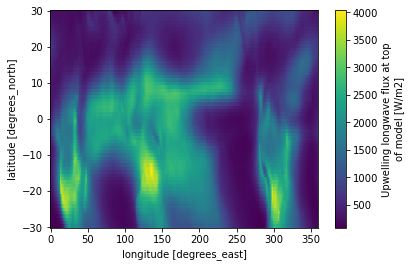

In [93]:
x_djf_totalvariance.plot.pcolormesh()

In [145]:
%%time
# okay, easy so far, but now we need to get the bandpass filtered variance

# frequency of data is 1/day
# want 2-180 day band
x_sampling_freq = 1 # 1 sample per day
x_resolution =  x_sampling_freq / len(ds.time)
cflow = (1/100)
cfhigh = (1/20)
x_bandpass = gc.fourier_filters.fourier_band_pass(xanom.sel(lat=slice(-30,30)), 1, cflow, cfhigh, time_axis=0)

CPU times: user 49 s, sys: 6.51 s, total: 55.5 s
Wall time: 46.8 s


In [146]:
x_bandpass_djf = season_selector(x_bandpass, "DJF")

In [147]:

# x_djf_filteredvariance = x_bandpass_djf.weighted(np.cos(np.radians(ds_djf['lat']))).var(dim='time')
x_djf_filteredvariance = x_bandpass_djf.var(dim='time')


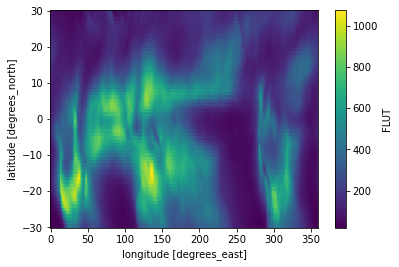

In [148]:
x_djf_filteredvariance.plot.pcolormesh()

In [149]:
# fraction of variance in the bandpass region:
x_variance_fraction = x_djf_filteredvariance / x_djf_totalvariance

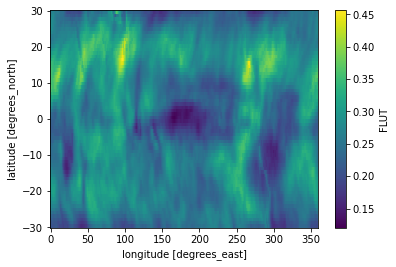

In [150]:
x_variance_fraction.plot.pcolormesh()

In [53]:
x_variance_fraction.min()

<xarray.DataArray 'FLUT' ()>
array(0.54306451)

In [60]:
#
#
#
uds = xr.open_dataset("/glade/work/brianpm/uwnd.day.850.anomalies.1980-2005.nc")
u = uds['U_anom'].sel(lat=0, lon=120, method='nearest').sel(time=slice("1995","1998"))
print(u)
fca     = 1./60.                        # start freq
fcb     = 1./30.                        # last  freq
ufft = gc.fourier_filters.fourier_band_pass(u, 1, fca, fcb, time_axis=0)

<xarray.DataArray 'U_anom' (time: 1461)>
array([-3.433455, -1.877689, -0.522301, ..., -0.079995, -1.608458,  0.681924],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1998-12-31
    lat      float32 0.0
    lon      float32 120.0
Attributes:
    long_name:  Anomalies: mean Daily U-wind
    units:      m/s


/glade/u/home/brianpm/miniconda3/envs/pten/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


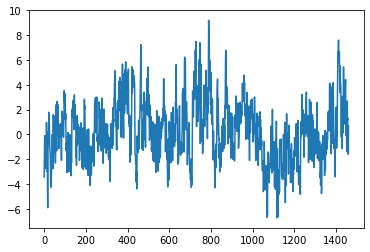

In [59]:
plt.plot(u)

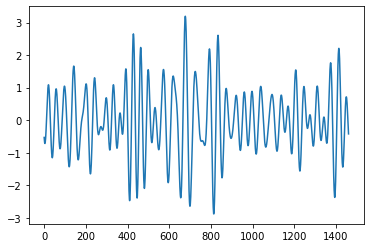

In [61]:
plt.plot(ufft)

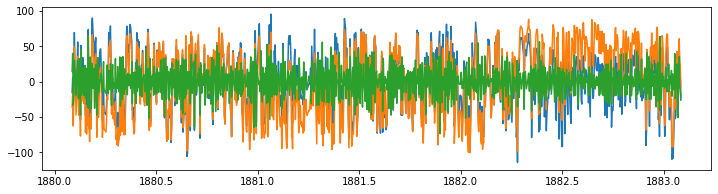

In [113]:
pt = x_bandpass.sel(lat=0, lon=120, method='nearest').sel(time=slice("1880","1882"))
pt0 = ds[VAR].sel(lat=0, lon=120, method='nearest').sel(time=slice("1880","1882"))
pt1 = gc.fourier_filters.fourier_band_pass(pt, 1/20, (1/100), 2, time_axis=0)
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(pt.time.dt.year+pt.time.dt.month/12+pt.time.dt.day/365, pt)
ax.plot(pt0.time.dt.year+pt0.time.dt.month/12+pt0.time.dt.day/365, pt0-pt0.mean())
ax.plot(pt0.time.dt.year+pt0.time.dt.month/12+pt0.time.dt.day/365, pt1)

In [119]:
onewinter = xanom.sel(lat=slice(-30,30), time=slice("1850-12-01","1851-02-28")).compute()

In [143]:
onewinter_filtered = gc.fourier_filters.fourier_band_pass(onewinter, 1, 1/180, 1, time_axis=0)

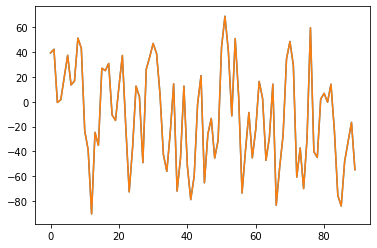

In [144]:
plt.plot(onewinter.sel(lat=0, lon=120, method='nearest'))
plt.plot(onewinter_filtered.sel(lat=0, lon=120, method='nearest'))